# Fundamentals of Machine Learning (CSCI-UA.473)
## Lab 6 : Convolutional Neural Networks (CNNs)

We will test the following assumptions pertaining to CNNs 

* Compositionality obtained using many layers
* Locality + stationarity of images assumed by the convolutional layers
* Invariance of object class to translations assumed by the pooling layers

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
from plot_lib import plot_data, plot_model, set_default

set_default()
# Get our device in a variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

### Load the Dataset (MNIST)

Load the MNIST handwritten digits dataset. We can use the PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches. Normalizing involves subtracting some coefficient (usually the mean) from each pixel values and dividing the resulting pixel values by another coefficient (usually the variance of the original pixel values). We also display some images.

In [3]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 9096777.39it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 16207612.23it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 4392894.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 5554090.02it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



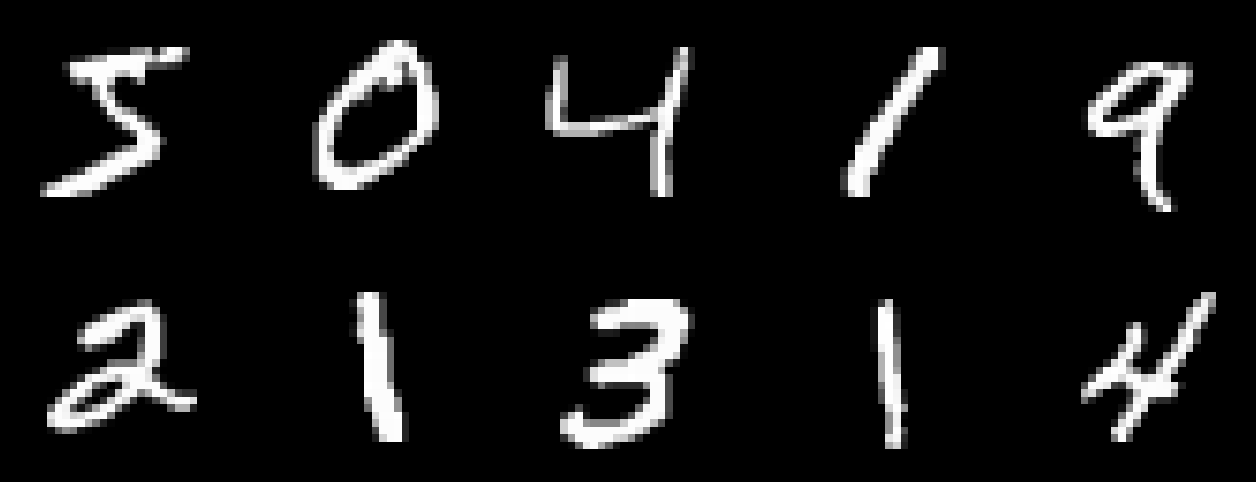

In [4]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.axis('off');

### Create the model classes
For comparison purposes we will create two models classes: 
1. Multi-layer Perceptron
2. Convolutional Neural Network

Pay special attention to the order of the layer while creating CNNs.

In [5]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size, activation='relu'):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        if activation =='relu':
            self.activation = nn.ReLU()  
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else :
            self.activation = nn.ReLU()
            print("Activation function not implemented, using default ReLU")
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            self.activation,
            nn.Linear(n_hidden, n_hidden), 
            self.activation,
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = x.view(-1, self.input_size)      
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size, activation='relu'):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        # n kernels will produce n feature maps --> n_feature = n_kernels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        # output of 1 will be used as an input for 2
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        if activation =='relu':
            self.activation = nn.ReLU()  
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else :
            print("Activation function not implemented, using default ReLU")
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x) # Will it make a difference if we apply the non-linearity after the pooling layer?
        
        # as long as the feature is present -- it's present, pooling helps with shift invariance
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = self.activation(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4) # this is where are flattening the 2D feature maps into a single 1D vector so as to be used by the subsequent fully connected layer
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [6]:
def train(epoch, model, optimizer, perm=torch.arange(0, 784).long(), verbose=False):
    model.train()
    epoch_loss = 0
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data to device, where the "device" is either a GPU if it exists or a CPU
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        # forward pass through the model
        output = model(data)
        # forward pass through the cross-entropy loss function
        loss = F.nll_loss(output, target)
        # backward pass through the cross-entropy loss function and the model
        loss.backward()
        
        optimizer.step()
        if batch_idx % 100 == 0:
            losses.append(loss.detach())
            if verbose :
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    return losses

def test(model, perm=torch.arange(0, 784).long(), verbose=False):
    model.eval()
    accuracy_list = []
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # send data to device, where the "device" is either a GPU if it exists or a CPU
            data, target = data.to(device), target.to(device)

            # permute pixels
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        accuracy_list.append(accuracy) 
        if verbose :
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                accuracy))
    return test_loss
        

### Train a small MLP

In [7]:
n_hidden = 8 # number of hidden units
model_fnn = FC2Layer(input_size, n_hidden, output_size)
# all the tensors have to be present in the GPU
model_fnn = model_fnn.to(device)

optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))
for epoch in range(0, 2):
    train(epoch, model_fnn, optimizer, verbose=True)
    test(model_fnn, verbose=True)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.392858
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.027153
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.396021
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.197938
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.848684
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.701947
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.007990
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.642056
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.809531
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.809561

Test set: Average loss: 0.5117, Accuracy: 8494/10000 (85%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.623786
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.763342
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.447496
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.576630
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.568844
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.390803
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.379390
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.352913
Train Epoch: 1 [51200/60

### Train a ConvNet with the same number of parameters
Play around with the hyper-parameters to understand their relationship with model performance.

## What is a parameter? 

In [8]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size, activation='relu')
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 2):
    train(epoch, model_cnn, optimizer, verbose=True)
    test(model_cnn, verbose=True)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301331
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.969617
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.627029
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.422143
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.212073
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.296998
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.190369
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.188637
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.266754
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.104172

Test set: Average loss: 0.1785, Accuracy: 9444/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.226964
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.318272
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.167404
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.074117
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.186945
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.165175
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.271739
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.118622
Train Epoch: 1 [51200/60

### ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

### What happens if the assumptions are no longer true?
Let us break the assumption of locality and permute the pixel within each image using an arbitrary permutation matrix. Also display the permuted images.

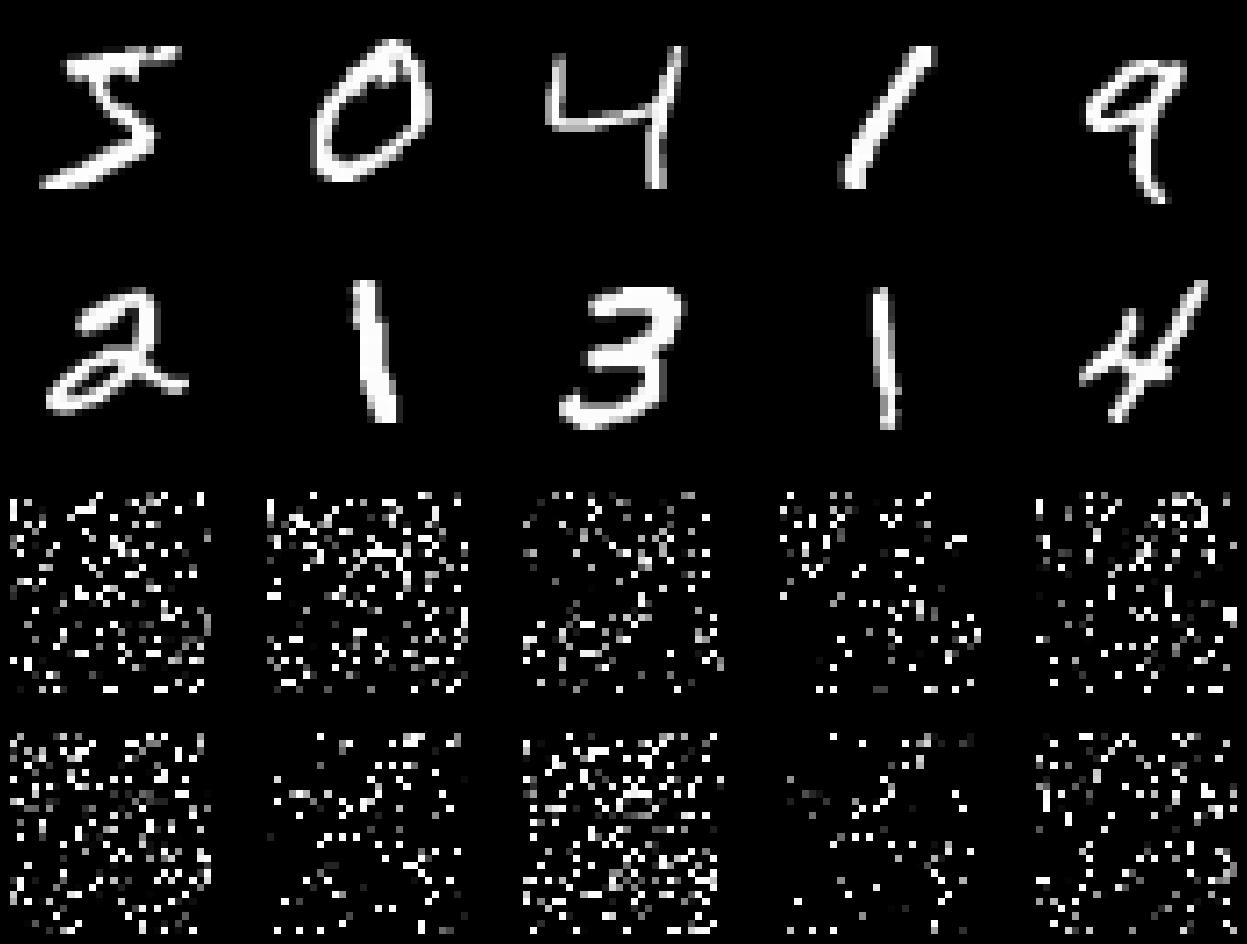

In [9]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy(), cmap='gray')
    plt.axis('off')

### CNNs with permuted pixels
What do you think will happen to CNNs when given permuted pixels as inputs? 

# CNNs do better when everything is connected in the right order, cause they find the correlation in the locality of the images

In [13]:
# Training settings 
n_features = 6 # number of feature maps


model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 3):
    train(epoch, model_cnn, optimizer, perm, verbose=True)
    test(model_cnn, perm, verbose=True)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.332854
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.252304
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.160389
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.363611
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.273751
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.926551
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.756077
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.076733
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.517536
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.368160

Test set: Average loss: 0.5306, Accuracy: 8404/10000 (84%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.459306
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.571384
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.568056
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.490740
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.274866
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.506500
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.475884
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.517419
Train Epoch: 1 [51200/60

### MLPs with permuted pixels (feed forward NN same results even with scrambled pixels)

In [10]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 2):
    train(epoch, model_fnn, optimizer, perm, verbose=True)
    test(model_fnn, perm, verbose=True)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314733
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.848276
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.096713
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.904389
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.640371
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.611448
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.506917
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.463162
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.453834
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.426821

Test set: Average loss: 0.4214, Accuracy: 8750/10000 (88%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.554379
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.574715
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.245440
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.225252
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.480143
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.212937
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.323001
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.274305
Train Epoch: 1 [51200/60

### Activation Functions
When we moved to Neural Networks we switched to ReLU as our activation function (or non-linearity). Recall that in logistic regression our non-linearty was the Sigmoid function. The sigmoid activation has a problem of vanishing gradients i.e. the gradients we get during backpropagation as often very close to 0. Think about what problem will this cause? In the next cell, we try both activations on our FC network and compare how the training proceeds.

# In sigmoid we frequently have the gradients close to 0, that's why SGD will be learning reaaally slow, whereas in ReLU we always have extreme paces

Number of parameters: 6442


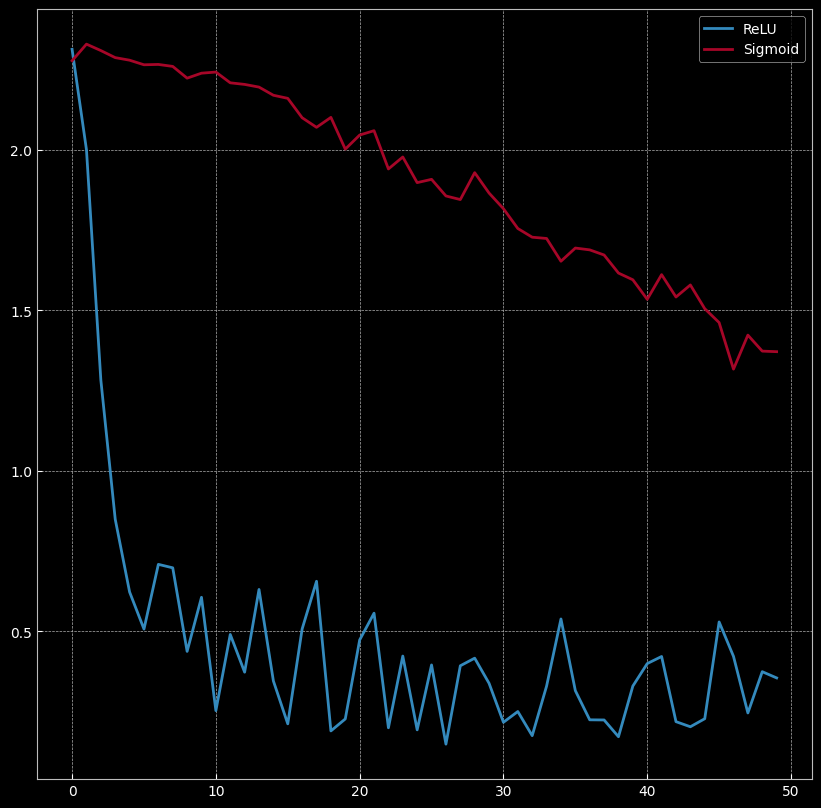

In [14]:
n_hidden = 8 # number of hidden units
model_fnn_1 = FC2Layer(input_size, n_hidden, output_size, activation='relu')
model_fnn_1 = model_fnn_1.to(device)
model_fnn_2 = FC2Layer(input_size, n_hidden, output_size, activation='sigmoid')
model_fnn_2 = model_fnn_2.to(device)

optimizer_1 = optim.SGD(model_fnn_1.parameters(), lr=0.01, momentum=0.5)
optimizer_2 = optim.SGD(model_fnn_2.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn_1)))
train_losses_1 = []
train_losses_2 = []
for epoch in range(0, 5):
    epoch_losses = train(epoch, model_fnn_1, optimizer_1)
    train_losses_1.extend(epoch_losses)
    epoch_losses = train(epoch, model_fnn_2, optimizer_2)
    train_losses_2.extend(epoch_losses)
plt.plot(train_losses_1, label='ReLU')
plt.plot(train_losses_2, label='Sigmoid')
plt.legend()
plt.show()

Think about why does the Sigmoid function have this issue but not the ReLU?

### Using Dropout to prevent overfitting
Dropout is a regularization technique which is now widely used to train deep neural networks. The idea is to randomly dropout some activations while training the models (Why would this help?). While the effect of using dropout is demonstrable for models on larger datasets (which takes longer to train!), we use a toy regression problem to demonstrate how dropout prevents overfitting.

# dropout is reducing model's dependency on a particular feature --> then generalizes better

In [15]:
N = 50 #number of data points
noise = 0.3

#generate the train data
X_train = torch.unsqueeze(torch.linspace(-1, 1, N),1)
Y_train = X_train + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

#generate the test data
X_test = torch.unsqueeze(torch.linspace(-1,1,N),1)
Y_test = X_test + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

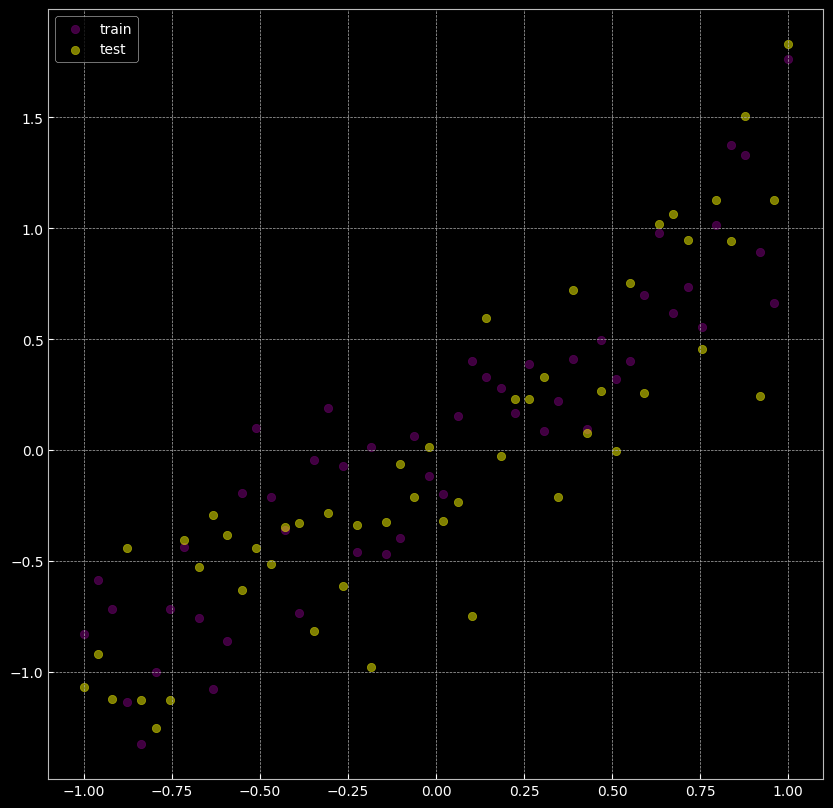

In [16]:
#create a neural network with out dropout
N_h = 100 #hidden nodes

model = torch.nn.Sequential(
    nn.Linear(1, N_h),
    nn.ReLU(),
    nn.Linear(N_h, N_h),
    nn.ReLU(),
    nn.Linear(N_h, 1)
)

#create a network with dropout
model_dropout = nn.Sequential(
    nn.Linear(1, N_h),
    nn.Dropout(0.5), #50 % probability the node is not considered for the next forward pass
    nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2), #20% probability
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [17]:
# Define number of hidden layers
N_h = 100

# Define a FC model
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

# Define a FC model with dropout -> simply add nn.Dropout(p) where p is the probability of randomly dropping out a node 
model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

In [18]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

# dropout is the way to regularize your NN

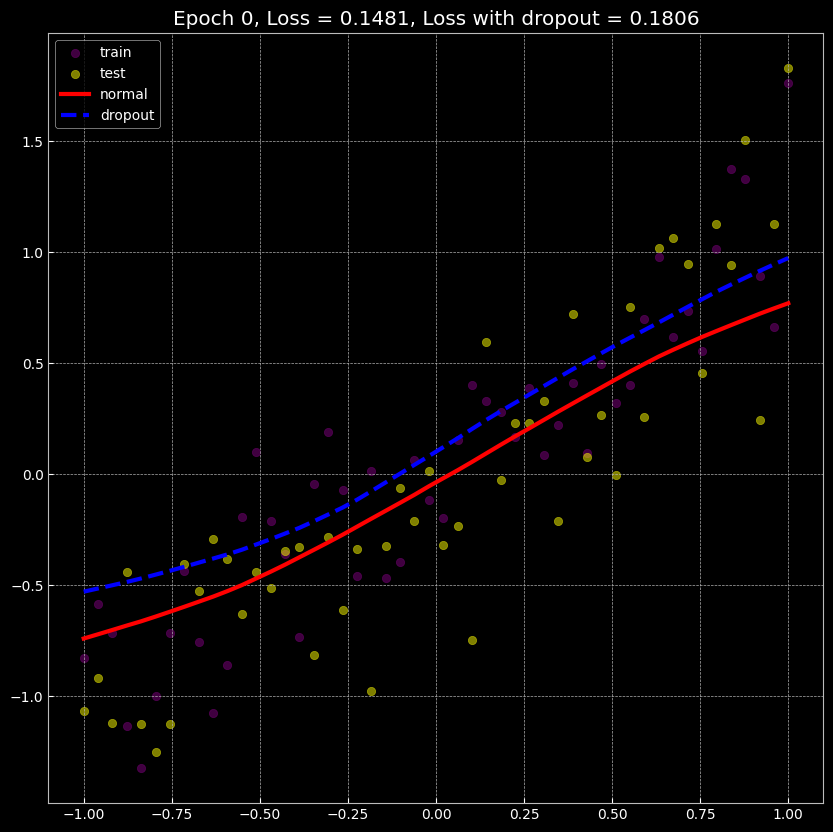

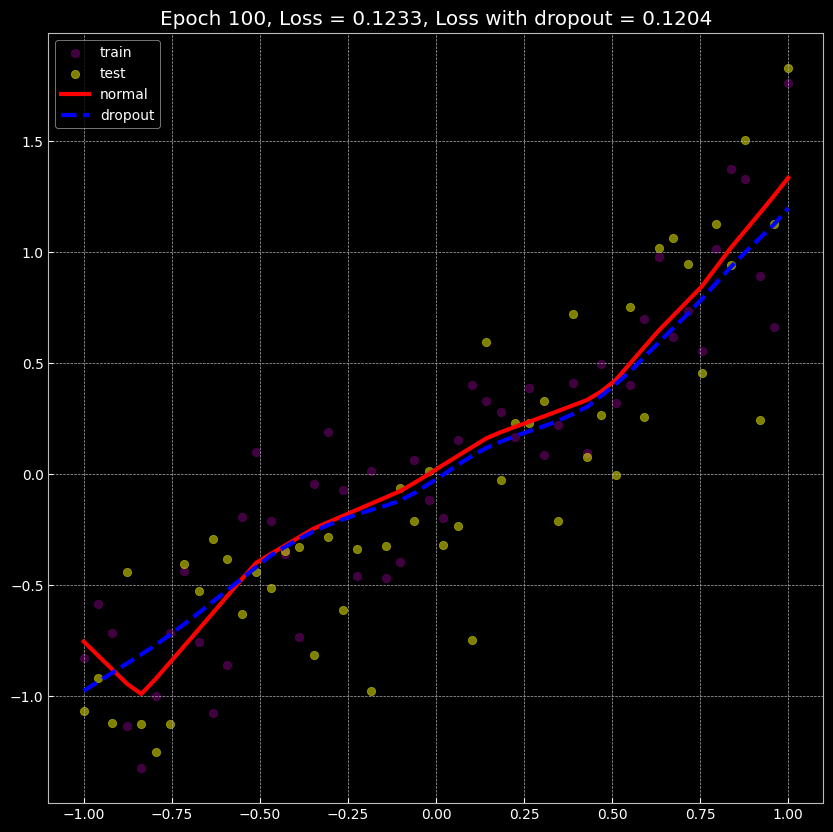

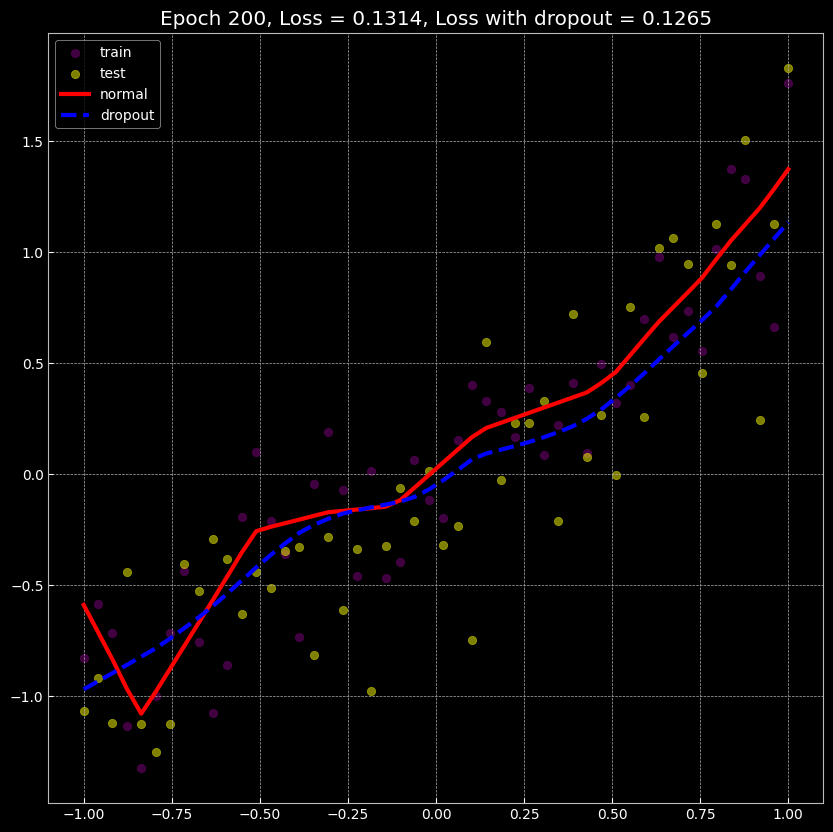

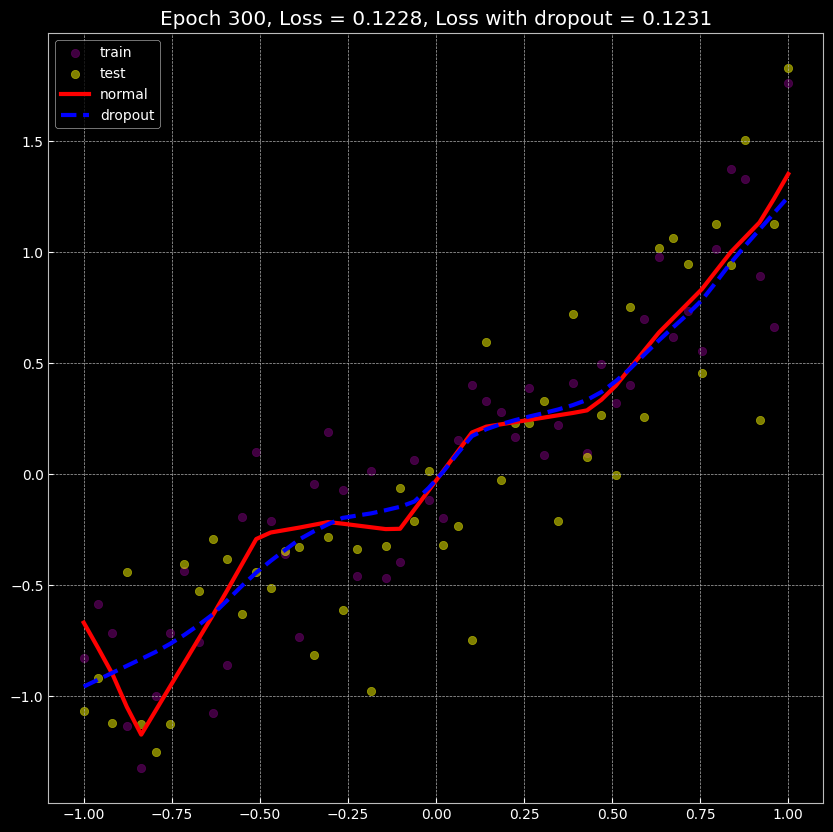

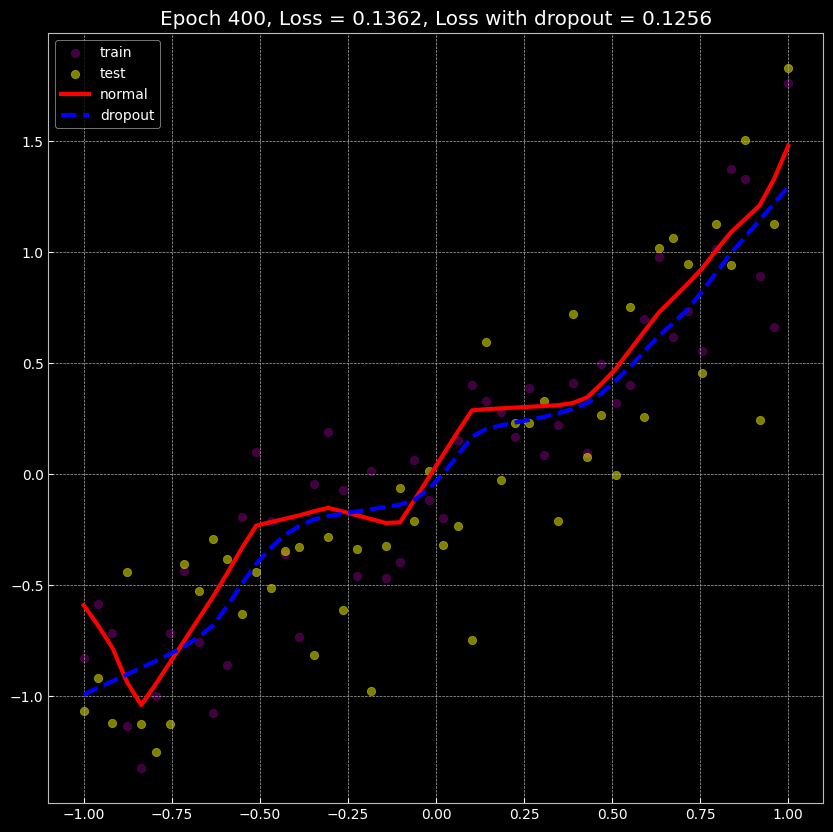

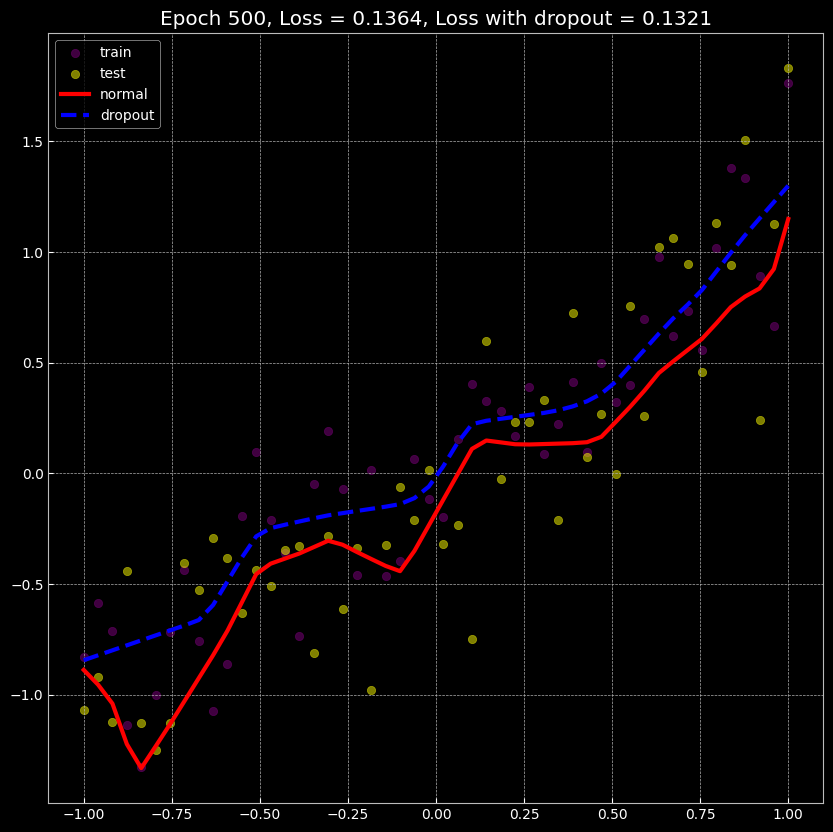

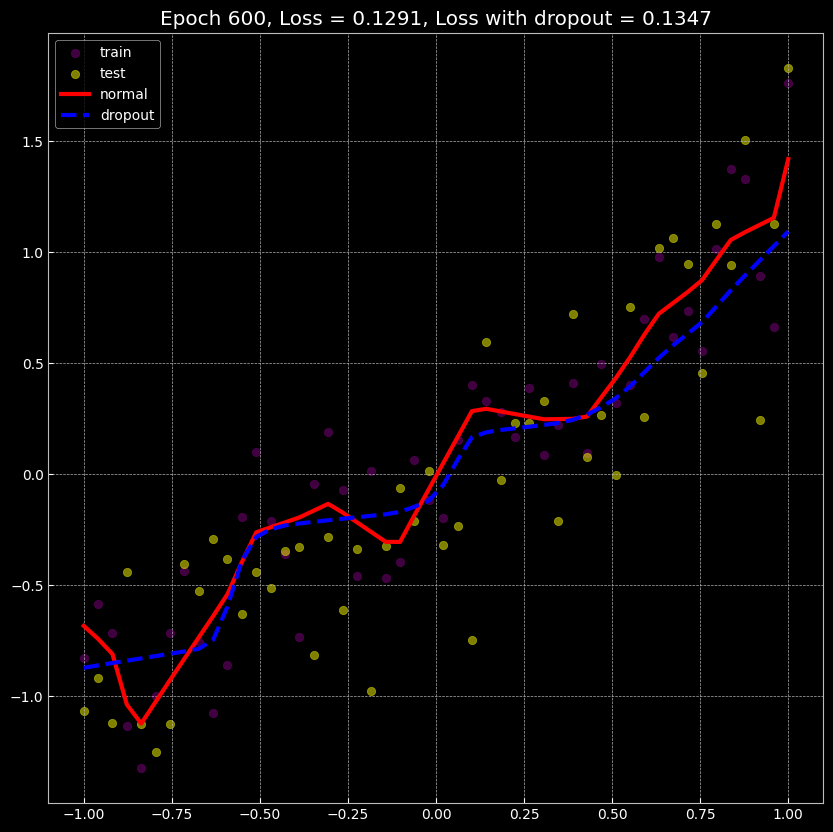

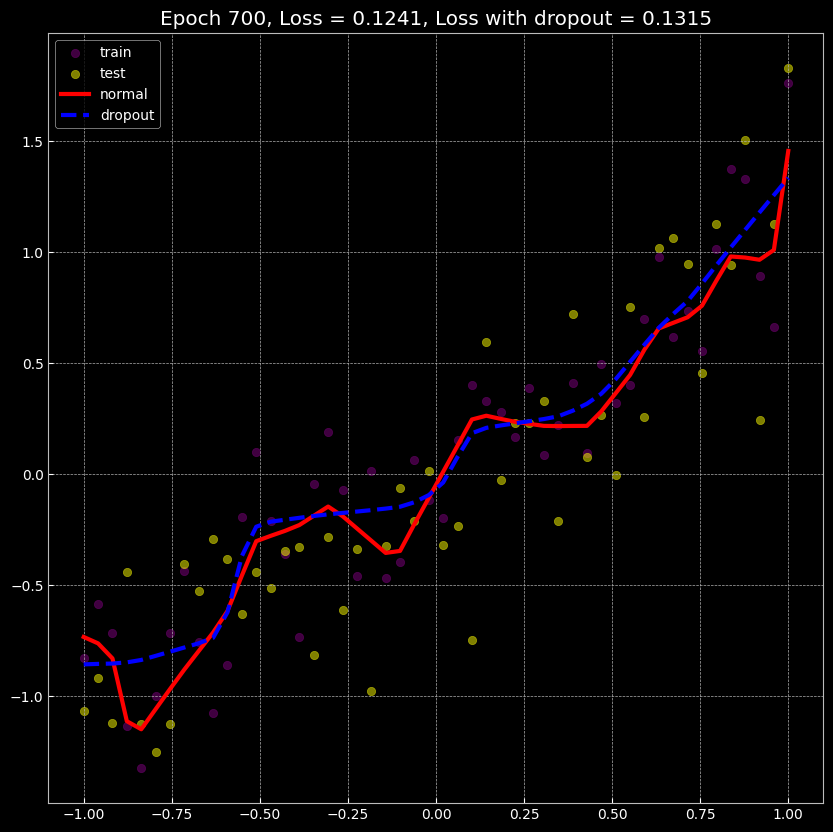

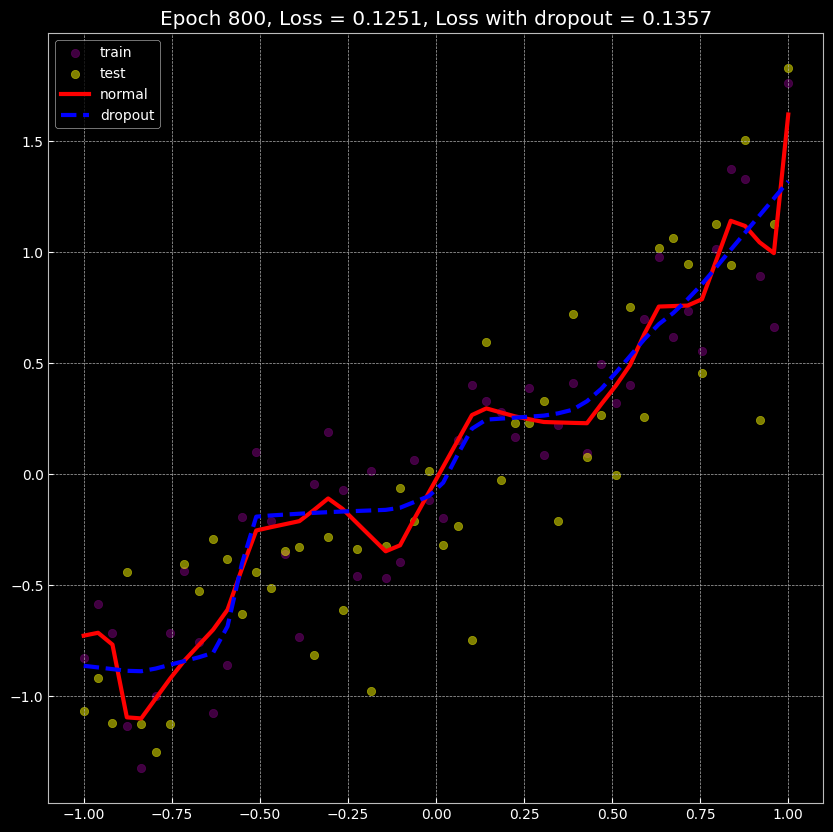

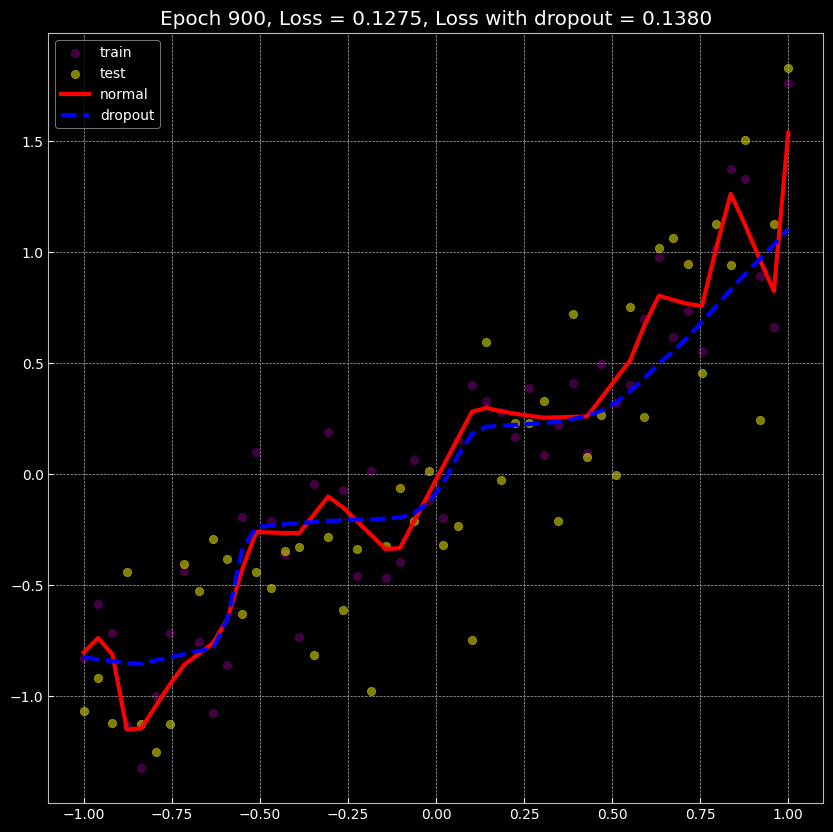

In [19]:
max_epochs = 1000

# Training blueprint - we are not using minibatches since our data is small enough to use it completely
for epoch in range(max_epochs):
    pred = model(X_train) 
    loss = loss_fn(pred, Y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pred_dropout = model_dropout(X_train)
    loss_dropout = loss_fn(pred_dropout, Y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()
    
    
    if epoch % 100 == 0:
        
        model.eval()
        model_dropout.eval()
        
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, Y_test)
        
        test_pred_dropout = model_dropout(X_test)
        test_loss_dropout = loss_fn(test_pred_dropout, Y_test)
        
        plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(X_test.data.numpy(), test_pred.data.numpy(), 'r-', lw=3, label='normal')
        plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3,  label='dropout')
        
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
        
        plt.legend()

        model.train()
        model_dropout.train()
        
        plt.pause(0.05)